# Import Library

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import ast

import warnings
warnings.filterwarnings('ignore')

#visualization libraries
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 10000)

# Read Data

In [2]:
trx = pd.read_csv("../input/fashion-campus/transactions.csv")
cust = pd.read_csv("../input/fashion-campus/customer.csv")
products = pd.read_csv('../input/fashion-campus/product.csv', on_bad_lines='skip')
click = pd.read_csv('../input/fashion-campus/click_stream.csv')

# Normalize JSON - click_stream

In [3]:
click['event_metadata'] = click['event_metadata'].fillna('{}')

In [4]:
click['event_metadata'] = click['event_metadata'].apply(ast.literal_eval)

In [5]:
click = pd.concat([click.drop(['event_metadata'], axis=1), pd.json_normalize(click['event_metadata'])], axis=1)

In [6]:
click.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN


# Explode JSON - transactions

In [7]:
trx['product_metadata'] = trx['product_metadata'].apply(ast.literal_eval)

In [8]:
transaction_new = trx.explode('product_metadata')

In [9]:
transaction_new = pd.concat([transaction_new.drop(['product_metadata'], axis=1), transaction_new['product_metadata'].apply(pd.Series)], axis=1)

In [10]:
transaction_new.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753


# Labelling

In [11]:
trx2 = transaction_new[transaction_new["payment_status"] == "Success"]
trx2.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753


In [12]:
cust_trx= pd.merge(cust[["customer_id","first_join_date"]],trx2[["customer_id","created_at"]], on = "customer_id", how = "left")
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaN
1,8193,2017-07-16,NaN
2,7279,2020-08-23,2020-08-23T12:53:12.916342Z
3,7279,2020-08-23,2020-08-23T12:53:12.916342Z
4,7279,2020-08-23,2020-08-31T13:34:59.916342Z
...,...,...,...
1250788,40573,2021-07-17,2021-10-21T15:43:07.139547Z
1250789,40573,2021-07-17,2022-01-23T19:01:48.139547Z
1250790,40573,2021-07-17,2022-03-11T19:03:09.139547Z
1250791,40573,2021-07-17,2022-04-27T20:00:55.139547Z


In [13]:
cust_trx["created_at"] = pd.to_datetime(cust_trx["created_at"])
cust_trx["first_join_date"] = pd.to_datetime(cust_trx["first_join_date"])

In [14]:
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaT
1,8193,2017-07-16,NaT
2,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
3,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
4,7279,2020-08-23,2020-08-31 13:34:59.916342+00:00
...,...,...,...
1250788,40573,2021-07-17,2021-10-21 15:43:07.139547+00:00
1250789,40573,2021-07-17,2022-01-23 19:01:48.139547+00:00
1250790,40573,2021-07-17,2022-03-11 19:03:09.139547+00:00
1250791,40573,2021-07-17,2022-04-27 20:00:55.139547+00:00


In [15]:
cust_trx['created_at'] = cust_trx['created_at'].dt.strftime('%Y-%m')
cust_trx['first_join_date'] = cust_trx['first_join_date'].dt.strftime('%Y-%m')

In [16]:
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07,NaN
1,8193,2017-07,NaN
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


## Cust nvr trx

In [17]:
cust_nvr_trx = cust_trx[cust_trx["created_at"].isna()]
cust_nvr_trx.shape

(49758, 3)

sebanyak 49.758 (unique) customer tidak pernah transaksi sukses, sisanya yakni 50.242 customer (unique) pernah transaksi sukses

## Cust trx

In [18]:
cust_trx2 = cust_trx[~cust_trx["created_at"].isna()]
cust_trx2.shape

(1201035, 3)

In [19]:
cust_trx2

,customer_id,first_join_date,created_at
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
5,7279,2020-08,2020-09
6,7279,2020-08,2020-09
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


In [20]:
# groupkan berdasarkan customer_id dan created_at
cust_trx4 = cust_trx2.groupby(["customer_id","created_at"])['first_join_date'].first().reset_index()

In [21]:
cust_trx4

,customer_id,created_at,first_join_date
0,3,2018-08,2018-08
1,3,2018-09,2018-08
2,3,2018-10,2018-08
3,3,2018-11,2018-08
4,3,2018-12,2018-08
...,...,...,...
565536,99998,2020-07,2018-07
565537,99998,2021-01,2018-07
565538,99998,2021-07,2018-07
565539,99998,2022-01,2018-07


In [22]:
cust_trx4["created_at"] = pd.to_datetime(cust_trx4["created_at"])

In [23]:
size = cust_trx4.shape[0]
#temp = pd.DataFrame(columns=['A'])
a = []
for i in range (size-1) :
    # jika nilai pada baris ke i di kolom ke 0 == nilai pada baris selanjutnya kolom ke 0 (merupakan cust yg sama)
    if cust_trx4.iloc[i,0] == cust_trx4.iloc[i+1,0] :
        # maka (created_at pada bulan next - created_at pd bulan before) dibagi 1 bulan
        # ini untuk mencari jarak bulan transaksi sukses selanjutnya
        a.append((cust_trx4.iloc[i+1,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))
    # jika nilai pada baris ke i di kolom ke 0 != nilai pada baris selanjutnya kolom ke 0 (merupakan cust yg berbeda)
    else :
        # maka (created_at pada bulan now - created_at pd bulan now) dibagi 1 bulan
        # alias hasilnya 0, alias itu transaksi terakhir si cust tsb, atau bisa jd dia cuma transaksi sekali
        a.append((cust_trx4.iloc[i,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))

In [24]:
diff = pd.DataFrame(a, columns = ["diff"])
diff = round(diff)
diff.head()

,diff
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0


In [25]:
# langsung aja concat kalo emang jumlah rowsnya sama dan yakin dia emang seharusnya ada di row itu

cust_trx5 = pd.concat([cust_trx4, diff], axis=1)
cust_trx5["diff"] = cust_trx5["diff"].fillna(0)
cust_trx5

,customer_id,created_at,first_join_date,diff
0,3,2018-08-01,2018-08,1.0
1,3,2018-09-01,2018-08,1.0
2,3,2018-10-01,2018-08,1.0
3,3,2018-11-01,2018-08,1.0
4,3,2018-12-01,2018-08,2.0
...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0
565537,99998,2021-01-01,2018-07,6.0
565538,99998,2021-07-01,2018-07,6.0
565539,99998,2022-01-01,2018-07,0.0


disini, 1 berati jarak antara transaksi bulan sekarang dengan transaksi selanjutnya, berjarak 1 bulan. kalo 0 berati dah gada transaksi lagi (ga dipake), kalo 2,3dst berati ya jarak antara transaksi bulan ini dgn transaksi selanjutnya berjarak sesuai angka itu (churn)

In [26]:
def renovated(df) : 
    if df["diff"] == 1 : 
        return 0
    elif df["diff"] == 0 :
        return 2
    else :
        return 1

    
cust_trx5["flagging"] = cust_trx5.apply(renovated, axis =1 )

disni berati, ketika jarak transaksi sekarang dgn selanjutnya adalah 1 bulan, dia akan dilabeli 0, maka dia terhitung transaksi rutin. kalo jaraknya 0 bulan, dia akan dilabeli 2, dan ketika jarak ke transaksi selanjutnya adalah di atas 1 bulan, dia akan dilabeli 1 (churn)

In [27]:
cust_trx5

,customer_id,created_at,first_join_date,diff,flagging
0,3,2018-08-01,2018-08,1.0,0
1,3,2018-09-01,2018-08,1.0,0
2,3,2018-10-01,2018-08,1.0,0
3,3,2018-11-01,2018-08,1.0,0
4,3,2018-12-01,2018-08,2.0,1
...,...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0,1
565537,99998,2021-01-01,2018-07,6.0,1
565538,99998,2021-07-01,2018-07,6.0,1
565539,99998,2022-01-01,2018-07,0.0,2


In [28]:
final_flagging = cust_trx5[cust_trx5["flagging"] <= 1].drop(columns=['diff'])
final_flagging

,customer_id,created_at,first_join_date,flagging
0,3,2018-08-01,2018-08,0
1,3,2018-09-01,2018-08,0
2,3,2018-10-01,2018-08,0
3,3,2018-11-01,2018-08,0
4,3,2018-12-01,2018-08,1
...,...,...,...,...
565534,99998,2019-07-01,2018-07,1
565535,99998,2020-01-01,2018-07,1
565536,99998,2020-07-01,2018-07,1
565537,99998,2021-01-01,2018-07,1


nah disini, yang label 2 di drop, yang mana jika cust tsb cuma trans sekali selama ini atau itu adalah transaksi terakhirnya, maka dia tidak akan diikutkan ke dalam pembuatan untuk feature

In [29]:
final_flagging["flagging"].value_counts(normalize = True)

0    0.620106
1    0.379894
Name: flagging, dtype: float64

- 1 adalah nasabah churn
- 0 adalah nasabah yang trx rutin

# Feature Engineering

## Traffic Source

In [30]:
# ini karena masing2 device pasti punya sessionnya masing-masing. tidak mungkin device yang berbeda
# memiliki session_id yang sama

click_traffic = click.groupby(['session_id'])[['traffic_source']].first().reset_index()

In [31]:
click_traffic

,session_id,traffic_source
0,00001f29-3ede-4445-95f0-0178934e32ba,MOBILE
1,00003eca-954b-4150-aee1-63fc62f395cf,MOBILE
2,0000425b-ddc8-4459-a240-6ba814dac132,MOBILE
3,00005746-17ec-449c-9c5c-699a3ea9304a,MOBILE
4,0000649b-9514-4600-979b-42166a798996,MOBILE
...,...,...
895198,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,WEB
895199,ffffd3d9-79db-459e-a427-388204a7aac7,MOBILE
895200,ffffdf8e-dea1-42bc-9839-7662675c0d38,MOBILE
895201,fffff7cf-2a18-4303-9c12-aa836ae3b543,MOBILE


In [32]:
trx_click = pd.merge(trx2[['created_at','customer_id','session_id']], click_traffic[['session_id','traffic_source']], on='session_id')

trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])
trx_click['created_at'] = trx_click['created_at'].dt.strftime('%Y-%m')
trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])

trx_click2 = trx_click.groupby(['customer_id','created_at','traffic_source']).count().reset_index()

In [33]:
trx_click3 = trx_click2.pivot_table('session_id', ['customer_id','created_at'], 'traffic_source', aggfunc=len, fill_value=0).reset_index()
trx_click3 = trx_click3.rename(columns = {
    'MOBILE' : 'mobile_used',
    'WEB' : 'web_used'
})

In [34]:
trx_click4 = final_flagging.merge(trx_click3, on=['customer_id','created_at'])
trx_click4

,customer_id,created_at,first_join_date,flagging,mobile_used,web_used
0,3,2018-08-01,2018-08,0,1,0
1,3,2018-09-01,2018-08,0,1,0
2,3,2018-10-01,2018-08,0,1,0
3,3,2018-11-01,2018-08,0,1,0
4,3,2018-12-01,2018-08,1,1,0
...,...,...,...,...,...,...
515293,99998,2019-07-01,2018-07,1,1,0
515294,99998,2020-01-01,2018-07,1,1,0
515295,99998,2020-07-01,2018-07,1,1,0
515296,99998,2021-01-01,2018-07,1,1,0


# Feature Selection

In [35]:
X = trx_click4.iloc[:,4:]
y = trx_click4[["flagging"]]

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (360708, 2)
Jumlah data testing:  (154590, 2)


In [37]:
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [38]:
iv_df = X_train.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

,Feature,iv
0,mobile_used,0.02201
1,web_used,0.032347


# Modelling

In [39]:
selected_features = ["mobile_used","web_used"]

In [40]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)
}

In [41]:
result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])

y_test = y_test.astype(int)

In [42]:
for key, classifier in classifiers.items():
    classifier.fit(X_train[selected_features], y_train)
    y_predict = classifier.predict(X_test[selected_features])
    
    yproba = classifier.predict_proba(X_test[selected_features])[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

0:	learn: 0.6631233	total: 108ms	remaining: 26.9s
25:	learn: 0.6332400	total: 815ms	remaining: 7.02s
50:	learn: 0.6332623	total: 1.47s	remaining: 5.73s
75:	learn: 0.6332667	total: 2.12s	remaining: 4.86s
100:	learn: 0.6332683	total: 2.78s	remaining: 4.11s
125:	learn: 0.6332683	total: 3.43s	remaining: 3.38s
150:	learn: 0.6332683	total: 4.08s	remaining: 2.67s
175:	learn: 0.6332683	total: 4.74s	remaining: 1.99s
200:	learn: 0.6332683	total: 5.39s	remaining: 1.31s
225:	learn: 0.6332683	total: 6.05s	remaining: 642ms
249:	learn: 0.6332683	total: 6.67s	remaining: 0us


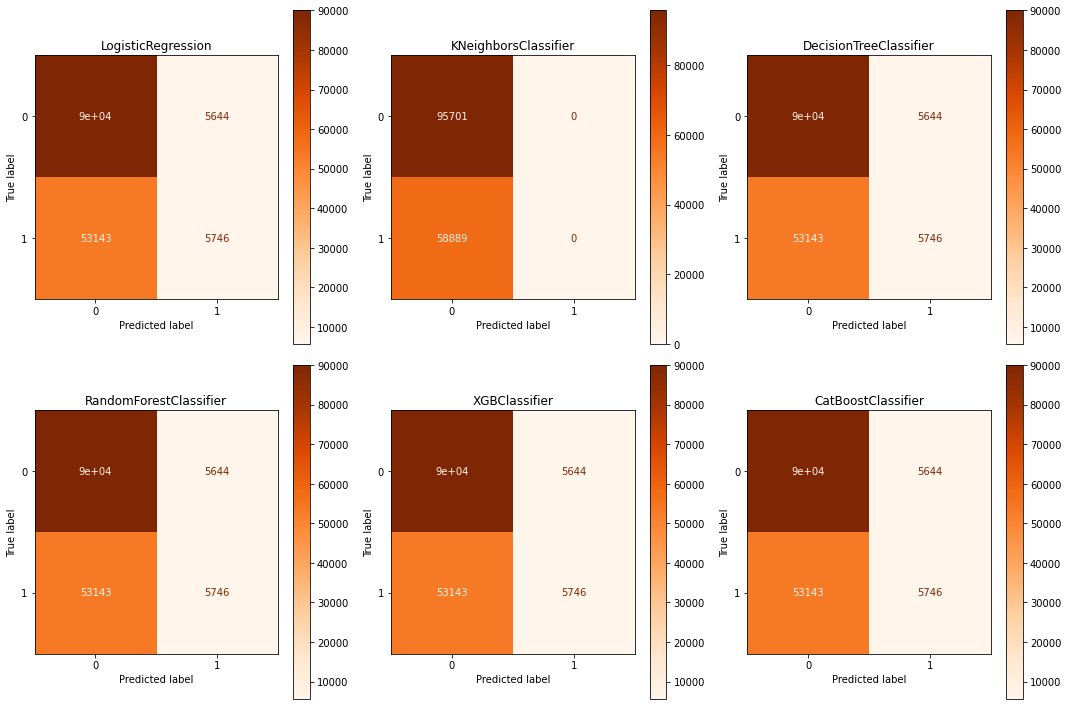

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test[selected_features], 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Performance

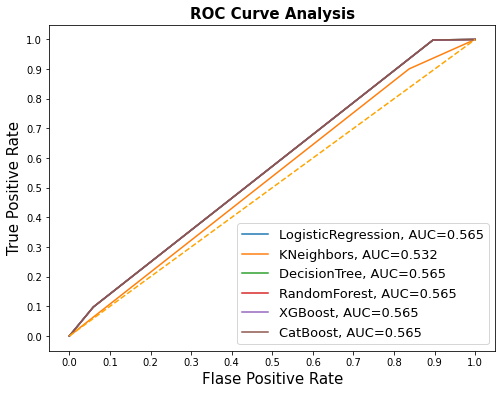

In [44]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [45]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.619723,0.581497,0.619723,0.529019
KNeighbors,0.619063,0.383239,0.619063,0.473409
DecisionTree,0.619723,0.581497,0.619723,0.529019
RandomForest,0.619723,0.581497,0.619723,0.529019
XGBoost,0.619723,0.581497,0.619723,0.529019
CatBoost,0.619723,0.581497,0.619723,0.529019
